# Pricing Test 

## Goal 
Pricing optimization is, non surprisingly, another area where data science can provide huge value. 
The goal here is to evaluate whether a pricing test running on the site has been successful. As always, you should focus on user segmentation and provide insights about segments who behave differently as well as any other insights you might find. 

## Challenge Description 
Company XYZ sells a software for 39 dollars. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66 percent of the users have seen the old price (39 dollars), while a random sample of 33 percent users a higher price (59 dollars). 
The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users. 
Especially he asked you the following questions: <br>
1) Should the company sell its software for 39 or 59 dollars? 

The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data? 

**Bonus:**<br>
2) The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why. 


In [846]:
import pandas as pd
import dtale as dtale
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as dates
import seaborn as sns
import bqplot as bqplot
from bqplot import pyplot as plt2
from scipy import stats
from datetime import datetime as dt

In [624]:
test_results = pd.read_csv('./Pricing_Test_data/test_results.csv')
user_table= pd.read_csv('./Pricing_Test_data/user_table.csv')

### Data validation
First, we want to look at the data to see what we're working with. Dtale provides an excel-like interface for scrolling and sorting our data frames:

In [748]:
dtale.show(user_table, ignore_duplicate=True)

In [626]:
dtale.show(test_results, ignore_duplicate=True)

One thing I noticed is that user_id is probably not unique to each individual. If you sort by timestamps, you'll see many duplicated rows. Therefore, you can drop the user_id columns and drop duplicated rows (asuming the same timestamp is very unlikely to have the same source, device, operating_system, test, and conversion fields)

In [627]:
print('Original shape of test_results: ' , test_results.shape)
test_results = test_results.drop(columns = ['user_id'])
test_results.drop_duplicates(inplace = True)
print('New shape of test_results: ' , test_results.shape)

Original shape of test_results:  (316800, 8)
New shape of test_results:  (143480, 7)


It's often helpful to see the data types and counts of unique values in each column. This allows us to see if we have duplicates where they aren't expected. The function below allows us to do that:

In [630]:
def printDFCounts(df, pLim = 12, allowHist = False):
    """ Shows all the unique elements in each column of a dataframe.
    pLim : (numeric) print limit - max number of rows to print for each feature
    allowHist : (boolean) allow binned counts of features when the # of unique feaures > pLim
    (e.g. when feature is continuous)
    Note: allowHist only works for numeric data.
    EX. printDFCounts(df = df, pLim = 25, allowHist = True)
    """
    print(df.info())
    featureCounts = []
    for feature in df.columns:
        value_counts = df[feature].value_counts()
        currFeature = dict(zip(list(value_counts.keys()), list(value_counts.values)))
        featureCounts.append(currFeature)

    print('\t value \t count')
    for f in range(len(df.columns)):
        print('{}: {}'.format(f,df.columns[f]))
    #     print('\t _____ \t _____' )
        if len(featureCounts[f].keys()) > pLim:
            if allowHist:
                feature = df.columns[f]
                edges = np.histogram(df[feature])[1]
                binWidth = np.diff(edges)[0]
                counts = np.histogram(df[feature])[0]
                keys = [str('%.1f'%edge) + ' - ' + str('%.1f'%(edge+binWidth)) for edge in edges[:-1]]
                print('\n'.join('\t {}: {}'.format(*k) for k in zip(keys,counts)))
            else:
                keys = list(featureCounts[f].keys())[0:pLim//2]
                counts = list(featureCounts[f].values())[0:pLim//2]
                print('\n'.join('\t {}: {}'.format(*k) for k in zip(keys,counts)))
                print('\t ...')
                keys = list(featureCounts[f].keys())[-pLim//2:]
                counts = list(featureCounts[f].values())[-pLim//2:]
                print('\n'.join('\t {}: {}'.format(*k) for k in zip(keys,counts)))
        else:
            keys = list(featureCounts[f].keys())
            counts = list(featureCounts[f].values())
            print('\n'.join('\t {}: {}'.format(*k) for k in zip(keys,counts)))
    return

printDFCounts(test_results, pLim = 20, allowHist = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143480 entries, 0 to 316793
Data columns (total 7 columns):
timestamp           143480 non-null object
source              143480 non-null object
device              143480 non-null object
operative_system    143480 non-null object
test                143480 non-null int64
price               143480 non-null int64
converted           143480 non-null int64
dtypes: int64(3), object(4)
memory usage: 8.8+ MB
None
	 value 	 count
0: timestamp
	 2015-05-30 10:02:09: 3
	 2015-05-16 12:35:56: 3
	 2015-04-03 12:26:44: 3
	 2015-03-27 16:42:23: 3
	 2015-04-25 12:05:19: 3
	 2015-05-23 09:38:21: 3
	 2015-05-30 11:28:45: 3
	 2015-04-17 12:53:16: 3
	 2015-04-11 11:23:54: 3
	 2015-05-08 09:20:13: 3
	 ...
	 2015-04-03 10:43:43: 1
	 2015-03-14 12:49:11: 1
	 2015-04-18 21:13:04: 1
	 2015-03-06 16:03:55: 1
	 2015-03-08 10:26:08: 1
	 2015-04-17 10:09:06: 1
	 2015-05-08 14:11:18: 1
	 2015-04-19 09:36:38: 1
	 2015-05-04 11:26:14: 1
	 2015-03-08 12:40:58: 1
1:

We can also see that about 1/3 of users saw the higher price as mentioned in the problem statement.

Several labels were mixed up, such that 'test = 0' corresponded to 'price = 59' and 'test = 1' corresponded to 'price = 39'. 

Therefore, we should drop those indecies:

In [682]:
dropIdxs = test_results[(test_results['price'] == 59) & (test_results['test'] == 0)].index
dropIdxs.append(test_results[(test_results['price'] == 39) & (test_results['test'] == 1)].index)
print('Original test resuts length:', test_results.shape[0])
df = test_results.drop(dropIdxs)
print('New test resuts length:', df.shape[0])

Original test resuts length: 143480
New test resuts length: 143384


Lastly, I'll convert the timestamp strings to dates so the dates: 

In [683]:
%%time
# First convert the timestamps to dates
df['timestamp'] = df['timestamp'].apply(lambda x: np.datetime64(x[0:10]))
df = df.sort_values(by='timestamp').reset_index(drop=True)
df_clean = df.copy() # We'll use this later

CPU times: user 175 ms, sys: 12.6 ms, total: 188 ms
Wall time: 155 ms


## Data analysis
Cacluate probablilty of conversion in the control and test groups:

In [684]:
n_con = df.query('test == 0').shape[0]
n_test = df.query('test == 1').shape[0]

p_con = df.query('test == 0').converted.sum()/n_con
p_test = df.query('test == 1').converted.sum()/n_test

# Calculate 95% confidence intervals:
n, p = n_con, p_con
CI_con = np.sqrt((p*(1-p))/n) * 1.96
n, p = n_test, p_con
CI_test = np.sqrt((p*(1-p))/n) * 1.96

print('Conversion probablity ± 95% CI:')
print('Control: {:.5f} ± {:.5f}'.format(p_con, CI_con))
print('Test: {:.5f} ± {:.5f}'.format(p_test, CI_test))

Conversion probablity ± 95% CI:
Control: 0.04381 ± 0.00132
Test: 0.03450 ± 0.00177


The probabilty of conversion decreases when we increase the price. <br>
What actually matters is how the expected revenue per person changes according to the pricing strategies:

95% CI for expected revenue per person (ERPP):
Control: 1.66 - 1.76
Test: 1.93 - 2.14


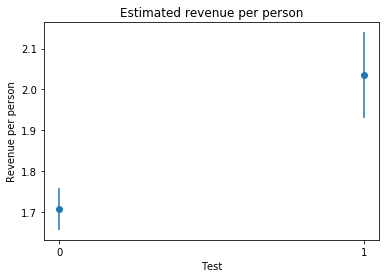

In [685]:
# Calculate 95% confidence intervals for revenue per person:
print('95% CI for expected revenue per person (ERPP):')
print('Control: {:.2f} - {:.2f}'.format((p_con-CI_con)*39, (p_con+CI_con)*39) )
print('Test: {:.2f} - {:.2f}'.format((p_test-CI_test)*59, (p_test+CI_test)*59) )

plt.errorbar([0,1], [p_con*39, p_test*59],yerr=[CI_con*39, CI_test*59], marker = 'o', linestyle= '')
plt.title('Estimated revenue per person')
plt.ylabel('Revenue per person')
plt.xlabel('Test')
plt.xticks([0,1])
plt.show()


We can be confident that the test yields signifcant increases in the ERPP since the errorbars don't overlap. <br>
There are several statistical tests we can utilize to see if we should utilize the new pricing strategy:

### A) One-sided t-test:
Purpose: To determine if the ERPP increases with the new pricing strategy. <br>
<br>
While the underlying data violates the assumption for a t-test that samples are normally distributed, the t-test is often used with data that isn't normally distributed. The data here is simply proportions weighted by the prices. I fourn that: 
"The t-test is basically not valid for testing the difference between two proportions. However, the t-test in proportions has been extensively studied, has been found to be robust, and is widely and successfully used in proportional data. With one exception: if one of the proportions is very close to zero, one or minus one, you will do better with Fisher’s exact test." 
https://www.quantitativeskills.com/sisa/statistics/t-thlp.htm <br> 
I think these proportions are close to zero so this may not be the best strategy...


In [686]:
a = df.query('test == 0').converted*39
b = df.query('test == 1').converted*59
stats.ttest_ind(b,a)

Ttest_indResult(statistic=6.534260160953018, pvalue=6.413766814068827e-11)

Since the t-statistic > 1.64 (the critcal value for one-sided t-test), this indicates that ERPP increases with the new pricing strategy.

## B)  Z-test of proportions 

We already know there are differences in the conversion rates, but what is ultimately important is that the new pricing strategy doesn't decrease conversion rate so much that it decreases ERPP. 

We can take a liberal estimate of the control conversion rate of 0.04513 (0.04381 + 0.00132), which is the upper limit of the 95% CI. Then, we can calculate the conversion rate under the new pricing strategy at which point we would break even:

In [687]:
r = 0.04513 * 39/59
print('Break even conversion rate: {:.5f}'.format(r))

Break even conversion rate: 0.02983


We'll then use the one-sample Z-test of proportions to see if the test conversion rate is greater than the breakeven conversion rate. Anything greater than the breakeven rate would yield a higer ERPP, which we already kind of know is true based on the confidence intervals we calculated earlier. <br>
<br>

<center> $Z_{statisic} = \frac{p - r} {\sqrt{\frac{p*q}{n}}}$ <br>
, where r is the liberal estimate for the breakeven conversion rate.</center>

In [688]:
z = (p_test-r)/np.sqrt(p_test * (1-p_test) * (1/n_test))
z

5.795140965057808

Since z > 1.645 we know that the test conversion rate is greater than the breakeven conversion rate (p<0.05). <br>
**Answer 1:** The new pricing strategy increased ERPP so the price should be set to $59. 

### Power calculations

The last question concerns how long should the test be run. The approach I took was to perform a sample size calculation for a 'noninferiority study' where we would ensure we have enough power to detect changes in conversion rate that would negatively impact revenue.

To put this another way, we want to ensure that our intervention does not negatively impact revenue which would happen when the conversion rate (liberal estimate: 0.0205) decreases below the breakeven rate (0.02983).
So the difference we are trying to detect is: 0.04513 - 0.02983 = 0.0153 <br>
*(Note: This power calculation assumes we know control conversion rate)*
<br>
<br>
We'll use this formula to calculate the sample size for the test group:
(Note we are just assuming the control group has a 0.0205 conversion rate, which was the liberal estimate).
<center>
$ n = (Z_{α/2}+Z_β)^2 * \frac{2*p*q}{(p-0.04513)^2}$ <br>
</center>
where $Z_{α/2}$ is the critical Z value for the two-sided test (1.96 when ⍺ = .05), * <br>
and $Z_{β}$ is the critical Z value related to 𝛽 (the false negative rate), which is often chosen to be 0.2, but we'll use .1 so that we have lower potential false negative rate : $Z_{.1}$ = 1.281. 

<br>* Even though we are doing a one-sided test, I think it's good to conduct the A/B test where we have sufficient power to detect changes in proportion of 0.0153 magnitude or greater in either direction. If anything, this will increase the power of our A/B test.

In [689]:
n = (1.96 + 1.282)**2 * 2*(0.02983*(1-0.02983)/(0.04513 - 0.02983)**2)
print('Number of samples needed in the test group: {:.0f}'.format(n))

Number of samples needed in the test group: 2599


Earlier, we saw that there were *way* more than 2599 test samples, so we were definitely overpowered:

test | Count <br>
------------- <br>
0    | 92084 <br>
1    | 51396 <br>


So the question is how did it take to collect ~2600 test samples? 

In [690]:
np.cumsum(df.groupby('timestamp')['test'].sum())[0:10]

timestamp
2015-03-02     250
2015-03-03     497
2015-03-04     708
2015-03-05    1205
2015-03-06    2372
2015-03-07    3321
2015-03-08    4060
2015-03-09    4291
2015-03-10    4531
2015-03-11    4752
Name: test, dtype: int64

This shows that it should have taken 6 days to collect enough test samples for the power analysis.

## Sanity check of our power analysis: 

I estimated that it would take 6 days to collect enough data, so lets see if that is true. 

Conversion probablity ± 95% CI:
Control: 0.04689 ± 0.00543
Test: 0.03914 ± 0.00719
95% CI for expected revenue per person (ERPP):
Control: 1.62 - 2.04
Test: 1.89 - 2.73


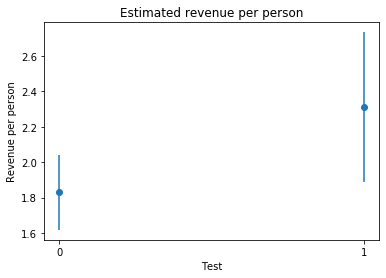

Ttest_indResult(statistic=2.3194783407235806, pvalue=0.020391038264615136)

In [692]:
df = df_clean.query("timestamp <= '2015-03-07' ")
n_con = df.query('test == 0').shape[0]
n_test = df.query('test == 1').shape[0]

p_con = df.query('test == 0').converted.sum()/n_con
p_test = df.query('test == 1').converted.sum()/n_test

# Calculate 95% confidence intervals:
n, p = n_con, p_con
CI_con = np.sqrt((p*(1-p))/n) * 1.96
n, p = n_test, p_con
CI_test = np.sqrt((p*(1-p))/n) * 1.96

print('Conversion probablity ± 95% CI:')
print('Control: {:.5f} ± {:.5f}'.format(p_con, CI_con))
print('Test: {:.5f} ± {:.5f}'.format(p_test, CI_test))

# Calculate 95% confidence intervals for revenue per person:
print('95% CI for expected revenue per person (ERPP):')
print('Control: {:.2f} - {:.2f}'.format((p_con-CI_con)*39, (p_con+CI_con)*39) )
print('Test: {:.2f} - {:.2f}'.format((p_test-CI_test)*59, (p_test+CI_test)*59) )

plt.errorbar([0,1], [p_con*39, p_test*59],yerr=[CI_con*39, CI_test*59], marker = 'o', linestyle= '')
plt.title('Estimated revenue per person')
plt.ylabel('Revenue per person')
plt.xlabel('Test')
plt.xticks([0,1])
plt.show()

a = df.query('test == 0').converted*39
b = df.query('test == 1').converted*59
stats.ttest_ind(b,a)

We can conclude at the end of 6 days that the higher price would yeild a higher revenue. The p-value is significant, but it's probably a good idea to select a lower 𝛽 value (like .05) since false negatives can be very costly. In other words, we don't want to prematurely conclude that the increased price does not negatively impact revenue. 

($Z_𝛽 = stats.norm.ppf(𝛽)$) 



For practical purposes, it's probably a good idea to run the test for at least a week so we capture all the dynamics of a typical week for the different types of users. Below, I'm showing that the new pricing has an advantage mainly on Friday and Saturday:

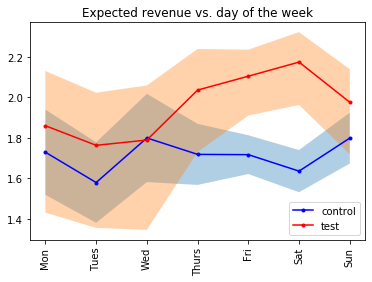

In [746]:
# Add days of the week to the dataframe:
df = df_clean.copy()
day_of_week = pd.Series([df['timestamp'][i].dayofweek for i in range(len(df))], name = 'day')
df = pd.concat([df, day_of_week], axis = 1)

n_con = df.query('test == 0').groupby('day').count()['converted']
p_con = (df.query('test == 0').groupby('day').sum()['converted']/n_con)
erpp_con_day = p_con*39

n_test = df.query('test == 1').groupby('day').count()['converted']
p_test = (df.query('test == 1').groupby('day').sum()['converted']/n_test)
erpp_test_day = p_test*59

plt.plot(range(7), erpp_con_day, color = 'b', marker='.', label = 'control')
plt.fill_between(range(7), erpp_con_day + 1.96*np.sqrt(p_con*(1-p_con)/n_con)*39, 
                 erpp_con_day - 1.96*np.sqrt(p_con*(1-p_con)/n_con)*39, alpha=.35)

plt.plot(range(7), erpp_test_day, color = 'r', marker='.', label = 'test')
plt.fill_between(range(7), erpp_test_day + 1.96*np.sqrt(p_test*(1-p_test)/n_con)*59, 
                 erpp_test_day - 1.96*np.sqrt(p_con*(1-p_test)/n_test)*59, alpha=.35)

plt.title('Expected revenue vs. day of the week')
plt.xticks(ticks = range(7), labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'], rotation = 90)
plt.legend(loc = 'lower right')
plt.show()

# Dashboard for the A/B test
Lastly, when conducting the A/B test it's probably a good idea to create a dashboard to monitor the data. We can track ERPP vs. date:

In [744]:
df = df_clean.copy()
n_con = np.cumsum(df.query('test == 0').groupby('timestamp').count()['converted'])
p_con = np.cumsum(df.query('test == 0').groupby('timestamp').sum()['converted'])/n_con
erpp_con = p_con*39

n_test = np.cumsum(df.query('test == 1').groupby('timestamp').count()['converted'])
p_test = np.cumsum(df.query('test == 1').groupby('timestamp').sum()['converted'])/n_test
erpp_test = p_test * 59 

t = sorted(df['timestamp'].unique())

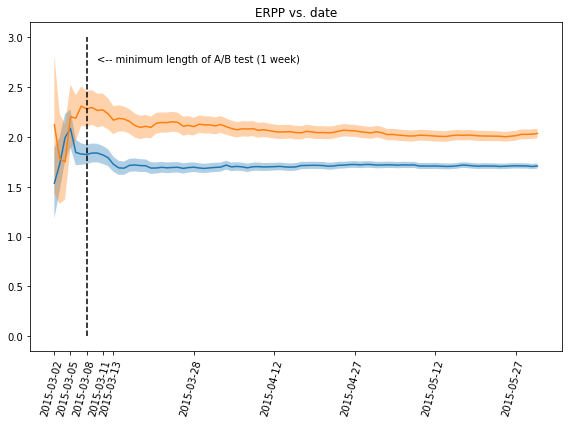

In [745]:
fig, ax = plt.subplots(figsize=(8, 6))
# Show the ERPP over the course of the A/B test
ax.plot(t, erpp_con)
ax.fill_between(t, erpp_con - np.sqrt(p_con*(1-p_con)/n_con)*39, erpp_con + np.sqrt(p_con*(1-p_con)/n_con)*39, alpha=0.35)
ax.plot(t, erpp_test)
ax.fill_between(t, erpp_test - np.sqrt(p_test*(1-p_test)/n_test)*59, erpp_test + np.sqrt(p_test*(1-p_test)/n_test)*59, alpha=0.35)
ax.plot([t[6], t[6]], [0, 3], color = 'k', linestyle = '--')
ax.text(t[8], 2.75, '<-- minimum length of A/B test (1 week)')
ax.set_xticks(dates.date2num(t[0:10:3] + t[11::15]))
plt.setp(ax.get_xticklabels(), rotation=75, ha="right", rotation_mode="anchor")
ax.set_title('ERPP vs. date')
plt.tight_layout()
plt.show()

# Show the avg ERPP for each day

# ax.plot(t, p_test)


This shows that over time we see clearer divergence between the two groups with smaller and smaller confidence intervals, but there are definitely diminishing returns after the dashed line at least in concluding that the test would not result in a loss in revenue.

# Other exploratory analyses

### Location related analyses can be performed if we merge the datasets:

In [763]:
test_results = pd.read_csv('./Pricing_Test_data/test_results.csv')
user_table= pd.read_csv('./Pricing_Test_data/user_table.csv')
dfMerged = user_table.merge(test_results, on='user_id')
print(dfMerged.shape)

dfMerged.drop(columns = ['user_id'], inplace = True)
dfMerged.drop_duplicates(inplace= True)
dfMerged.reset_index(drop=True, inplace = True)
print(dfMerged.shape)

(275616, 12)

We can see Austin has the highest conversion rates for cities with >500/users per city:

In [834]:
n_city = pd.Series(dfMerged.groupby('city').count()['converted'], name = 'N')
conversionRate_city = pd.Series(dfMerged.groupby('city').sum()['converted']/ n_city, name ='Conversion rate')
conversionRate_cityDF = pd.concat([dfMerged.groupby('city').median()[['lat','long']], conversionRate_city, n_city], axis=1)
conversionRate_cityDF.sort_values(by='Conversion rate', ascending=False, inplace=True)
dtale.show(conversionRate_cityDF.query('N > 500'), ignore_duplicate=True)

### Map of conversion rates
Below is a map of conversion rates by city where we have more than 200 users/city:

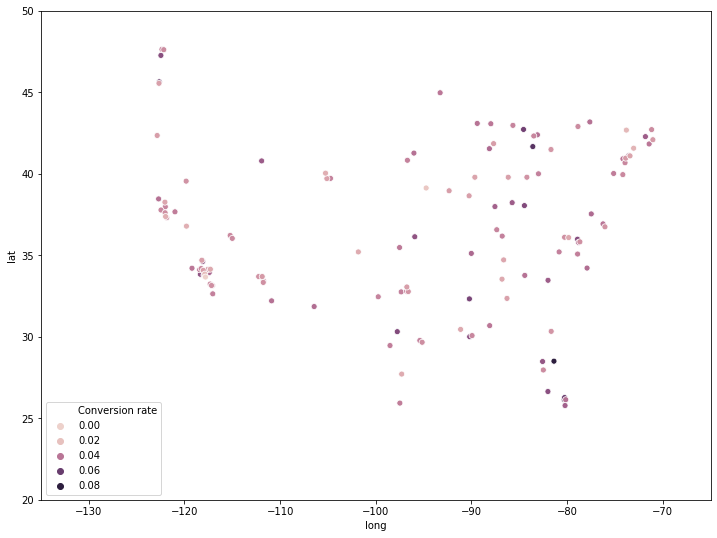

In [843]:
plt.subplots(figsize=(12,9))
sns.scatterplot(x='long', y='lat', hue='Conversion rate', data=conversionRate_cityDF.query('N>200'))
plt.legend(loc='lower left')
plt.xlim([-135,-65])
plt.ylim([20,50])
plt.show()